In [1]:
#!pip install nltk

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale ,LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### NLP (Lemmatization , Vectorization )

Text data needs to be converted to numeric representations before they can be used to train deep learning models. The Spam classification feature data is converted to TF-IDF vectors and the target variable is converted to one-hot encoding.

In [4]:
spam_data = pd.read_csv("Spam-Classification.csv")

In [5]:
spam_data.head()

,CLASS,SMS
0,ham,"said kiss, kiss, i can't do the sound effects..."
1,ham,&lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3,spam,* FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4,spam,**FREE MESSAGE**Thanks for using the Auction S...


In [6]:
#Separate feature and target data
spam_classes_raw = spam_data["CLASS"]
spam_messages = spam_data["SMS"]

In [7]:
spam_classes_raw

0        ham
1        ham
2       spam
3       spam
4       spam
        ... 
1495     ham
1496     ham
1497     ham
1498     ham
1499    spam
Name: CLASS, Length: 1500, dtype: object

In [8]:
spam_messages

0        said kiss, kiss, i can't do the sound effects...
1           &lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2       (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3       * FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4       **FREE MESSAGE**Thanks for using the Auction S...
                              ...                        
1495         Yup, no need. I'll jus wait 4 e rain 2 stop.
1496    Yup... From what i remb... I think should be c...
1497                             Yup... How Ã¼ noe leh...
1498    Yup... Ok i go home look at the timings then i...
1499    <Forwarded from 21870000>Hi - this is your Mai...
Name: SMS, Length: 1500, dtype: object

Stemming is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling. **Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.**

Lemmatization Example :

-> rocks : rock

-> corpora : corpus

-> better : good

In [9]:
#Custom tokenizer to remove stopwords and use lemmatization
lemmatizer = WordNetLemmatizer()

def customtokenize(str):
    #Split string as tokens
    tokens=nltk.word_tokenize(str)
    #Filter for stopwords
    nostop = list(filter(lambda token: token not in stopwords.words('english'), tokens))
    #Perform lemmatization
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

In [10]:
#Build a TF-IDF Vectorizer model with tokenizer
vectorizer = TfidfVectorizer(tokenizer=customtokenize)

In [11]:
#Transform feature input to TF-IDF
tfidf=vectorizer.fit_transform(spam_messages)
#Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
#Build a label encoder for target variable to convert strings to numeric values.
label_encoder = LabelEncoder()
spam_classes = label_encoder.fit_transform(spam_classes_raw)

### Label Encoding



In [13]:
spam_classes

array([0, 0, 1, ..., 0, 0, 1])

In [14]:
#Convert target to one-hot encoding vector
spam_classes = tf.keras.utils.to_categorical(spam_classes,2)

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", spam_classes.shape)



TF-IDF Matrix Shape :  (1500, 4566)
One-hot Encoding Shape :  (1500, 2)


### Train Test Split

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split( tfidf_array, spam_classes, test_size=0.1)

In [16]:
X_train.shape,X_train.shape[1]

((1350, 4566), 4566)

In [17]:
X_train[4]

array([0., 0., 0., ..., 0., 0., 0.])

### Building and Evaluating the Model

In [18]:
#Setup Hyper Parameters for building the model
num_classes=2
nodes_hidden=32

model = tf.keras.models.Sequential()

model.add(keras.layers.Dense(nodes_hidden,
                             input_shape=(X_train.shape[1],),
                              name='Hidden-Layer-1',
                              activation='relu'))

model.add(keras.layers.Dense(nodes_hidden,
                              name='Hidden-Layer-2',
                              activation='relu'))

model.add(keras.layers.Dense(num_classes,
                             name='Output-Layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 32)                146144    
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                1056      
                                                                 
 Output-Layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 147266 (575.26 KB)
Trainable params: 147266 (575.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training
BATCH_SIZE=256
EPOCHS=10
VALIDATION_SPLIT=0.2


history=model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

Epoch 1/10
5/5 [==============================] - 1s 70ms/step - loss: 0.6891 - accuracy: 0.6231 - val_loss: 0.6781 - val_accuracy: 0.8000
Epoch 2/10
5/5 [==============================] - 0s 21ms/step - loss: 0.6614 - accuracy: 0.8935 - val_loss: 0.6417 - val_accuracy: 0.8889
Epoch 3/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6138 - accuracy: 0.9546 - val_loss: 0.5999 - val_accuracy: 0.9148
Epoch 4/10
5/5 [==============================] - 0s 19ms/step - loss: 0.5604 - accuracy: 0.9759 - val_loss: 0.5556 - val_accuracy: 0.8963
Epoch 5/10
5/5 [==============================] - 0s 19ms/step - loss: 0.5055 - accuracy: 0.9769 - val_loss: 0.5118 - val_accuracy: 0.9222
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 0.4507 - accuracy: 0.9806 - val_loss: 0.4692 - val_accuracy: 0.9259
Epoch 7/10
5/5 [==============================] - 0s 19ms/step - loss: 0.3976 - accuracy: 0.9824 - val_loss: 0.4276 - val_accuracy: 0.9333
Epoch 8/10
5/5 [===========

### Plotting Accuracy against epochs

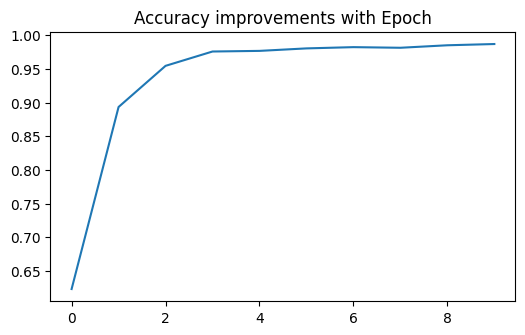

In [20]:
pd.DataFrame(history.history)["accuracy"].plot(figsize=(6, 3.5))
plt.title("Accuracy improvements with Epoch")
plt.show()

### Model Evaluation against Test Data

In [21]:
model.evaluate(X_test,Y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.3026 - accuracy: 0.9667


[0.3025989830493927, 0.9666666388511658]

### Predicting for Text

In [22]:
#Predict for multiple samples using batch processing

#Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(["FREE entry to a fun contest",
                                    "Yup I will come over",
                                    "Please keep the entry gate open",
                                    "We both have a arm wrestling contest "]).toarray()

print(predict_tfidf.shape)

#Predict using model
prediction=np.argmax( model.predict(predict_tfidf), axis=1 )
print("Prediction Output:" , prediction)

#Print prediction classes
print("Prediction Classes are ", label_encoder.inverse_transform(prediction))

(4, 4566)
1/1 [==============================] - 0s 90ms/step
Prediction Output: [1 0 0 0]
Prediction Classes are  ['spam' 'ham' 'ham' 'ham']
